# Performance Analysis: Matrix Dimensions vs einsumcorr Performance

This notebook explores the relationship between matrix size (particularly column dimensionality) and the performance of the `einsumcorr` package compared to standard numpy correlation computation.

## Hypothesis
The number of columns affects performance more than the number of rows, since correlation is computed between columns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from einsumcorr import optcorr
import torch

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"Using device: {'GPU (MPS)' if torch.backends.mps.is_available() else 'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")

Using device: GPU (MPS)


## Helper Functions

In [2]:
def time_function(func, *args, n_runs=1):
    """Time a function over multiple runs and return mean time."""
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        result = func(*args)
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times), result

def numpy_corrcoef(x):
    """Standard numpy correlation computation."""
    return np.corrcoef(x.T)

def generate_test_matrix(n_rows, n_cols, seed=42):
    """Generate a random test matrix."""
    np.random.seed(seed)
    return np.random.randn(n_rows, n_cols)

## Experiment 1: Effect of Column Dimensionality

Test performance across different numbers of columns while keeping rows constant.

In [3]:
# Test parameters
n_rows_fixed = 1000  # Fixed number of rows
col_dimensions = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000, 10000, 20000]
n_runs = 3

results_cols = []

print("Testing column dimensionality effect...")
print(f"Fixed rows: {n_rows_fixed}")
print("Columns:", end=" ")

for n_cols in col_dimensions:
    print(f"{n_cols}", end=" ", flush=True)
    
    # Generate test matrix
    X = generate_test_matrix(n_rows_fixed, n_cols)
    
    # Time optcorr
    time_optcorr, result_optcorr = time_function(optcorr, X, n_runs=n_runs)
    
    # Time numpy corrcoef
    time_numpy, result_numpy = time_function(numpy_corrcoef, X, n_runs=n_runs)
    
    # Verify results match (within tolerance)
    max_diff = np.max(np.abs(result_optcorr - result_numpy))
    
    results_cols.append({
        'n_rows': n_rows_fixed,
        'n_cols': n_cols,
        'time_optcorr': time_optcorr,
        'time_numpy': time_numpy,
        'speedup': time_numpy / time_optcorr if time_optcorr > 0 else float('inf'),
        'max_diff': max_diff
    })

print("\nDone!")
df_cols = pd.DataFrame(results_cols)
print(df_cols)

Testing column dimensionality effect...
Fixed rows: 1000
Columns: 5 10 20 50 100 200 500 1000 1500 2000 2500 3000 4000 5000 10000 20000 
Done!
    n_rows  n_cols  time_optcorr  time_numpy   speedup  max_diff
0     1000       5      0.000208    0.000042  0.199623  0.000000
1     1000      10      0.000127    0.000048  0.378269  0.000000
2     1000      20      0.000213    0.000060  0.282250  0.000000
3     1000      50      0.000106    0.000078  0.733562  0.000000
4     1000     100      0.000170    0.000132  0.776592  0.000000
5     1000     200      0.000458    0.000376  0.821407  0.000000
6     1000     500      0.001791    0.001657  0.925650  0.000000
7     1000    1000      0.005362    0.005013  0.934781  0.000000
8     1000    1500      0.009689    0.008907  0.919352  0.000000
9     1000    2000      0.016128    0.014856  0.921094  0.000000
10    1000    2500      0.036135    0.024692  0.683329  0.000002
11    1000    3000      0.021460    0.036123  1.683256  0.000002
12    1000  

## Experiment 2: Effect of Row Dimensionality

Test performance across different numbers of rows while keeping columns constant.

In [4]:
# Test parameters
n_cols_fixed = 2500  # Fixed number of columns
row_dimensions = [100, 200, 500, 1000, 2000, 5000, 10000]

results_rows = []

print("Testing row dimensionality effect...")
print(f"Fixed columns: {n_cols_fixed}")
print("Rows:", end=" ")

for n_rows in row_dimensions:
    print(f"{n_rows}", end=" ", flush=True)
    
    # Generate test matrix
    X = generate_test_matrix(n_rows, n_cols_fixed)
    
    # Time optcorr
    time_optcorr, result_optcorr = time_function(optcorr, X, n_runs=n_runs)
    
    # Time numpy corrcoef
    time_numpy, result_numpy = time_function(numpy_corrcoef, X, n_runs=n_runs)
    
    # Verify results match (within tolerance)
    max_diff = np.max(np.abs(result_optcorr - result_numpy))
    
    results_rows.append({
        'n_rows': n_rows,
        'n_cols': n_cols_fixed,
        'time_optcorr': time_optcorr,
        'time_numpy': time_numpy,
        'speedup': time_numpy / time_optcorr if time_optcorr > 0 else float('inf'),
        'max_diff': max_diff
    })

print("\nDone!")
df_rows = pd.DataFrame(results_rows)
print(df_rows)

Testing row dimensionality effect...
Fixed columns: 2500
Rows: 100 200 500 1000 2000 5000 10000 
Done!
   n_rows  n_cols  time_optcorr  time_numpy   speedup      max_diff
0     100    2500      0.019140    0.015416  0.805430  5.960464e-07
1     200    2500      0.010421    0.016842  1.616137  7.152557e-07
2     500    2500      0.013438    0.018278  1.360198  9.536743e-07
3    1000    2500      0.013099    0.026009  1.985646  1.609325e-06
4    2000    2500      0.020436    0.037646  1.842140  3.099442e-06
5    5000    2500      0.039031    0.072072  1.846535  4.291534e-06
6   10000    2500      0.064455    0.124846  1.936939  5.066395e-06


## Visualization: Performance vs Column Dimensionality

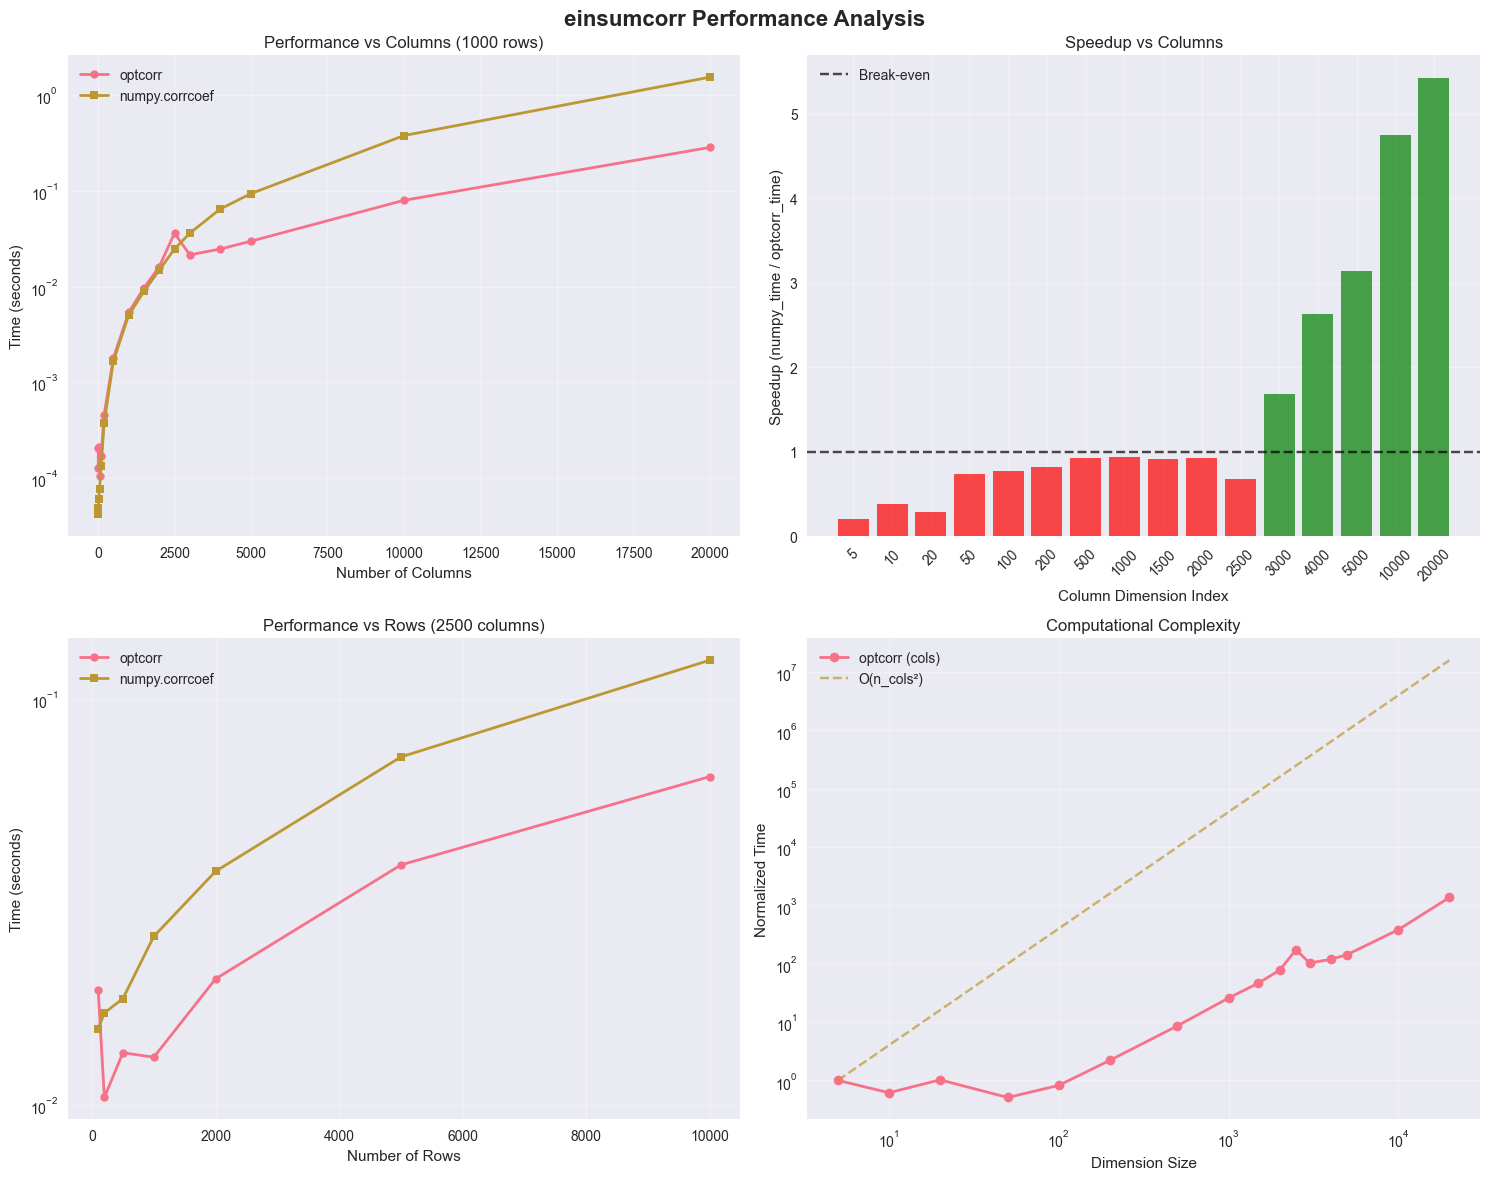

In [5]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('einsumcorr Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Timing vs Columns
ax1 = axes[0, 0]
ax1.plot(df_cols['n_cols'], df_cols['time_optcorr'], 'o-', label='optcorr', linewidth=2, markersize=6)
ax1.plot(df_cols['n_cols'], df_cols['time_numpy'], 's-', label='numpy.corrcoef', linewidth=2, markersize=6)
ax1.set_xlabel('Number of Columns')
ax1.set_ylabel('Time (seconds)')
ax1.set_title(f'Performance vs Columns ({n_rows_fixed} rows)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Speedup vs Columns
ax2 = axes[0, 1]
colors = ['red' if x < 1 else 'green' for x in df_cols['speedup']]
ax2.bar(range(len(df_cols)), df_cols['speedup'], color=colors, alpha=0.7)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Break-even')
ax2.set_xlabel('Column Dimension Index')
ax2.set_ylabel('Speedup (numpy_time / optcorr_time)')
ax2.set_title('Speedup vs Columns')
ax2.set_xticks(range(len(df_cols)))
ax2.set_xticklabels(df_cols['n_cols'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Timing vs Rows
ax3 = axes[1, 0]
ax3.plot(df_rows['n_rows'], df_rows['time_optcorr'], 'o-', label='optcorr', linewidth=2, markersize=6)
ax3.plot(df_rows['n_rows'], df_rows['time_numpy'], 's-', label='numpy.corrcoef', linewidth=2, markersize=6)
ax3.set_xlabel('Number of Rows')
ax3.set_ylabel('Time (seconds)')
ax3.set_title(f'Performance vs Rows ({n_cols_fixed} columns)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Computational Complexity Analysis
ax4 = axes[1, 1]
# Theoretical complexity: O(n_cols^2 * n_rows) for correlation
theoretical_cols = df_cols['n_cols']**2 * n_rows_fixed
theoretical_rows = df_rows['n_rows'] * n_cols_fixed**2

# Normalize for comparison
ax4.plot(df_cols['n_cols'], df_cols['time_optcorr'] / df_cols['time_optcorr'].iloc[0], 
         'o-', label='optcorr (cols)', linewidth=2)
ax4.plot(df_cols['n_cols'], theoretical_cols / theoretical_cols[0], 
         '--', label='O(n_cols²)', alpha=0.7)
ax4.set_xlabel('Dimension Size')
ax4.set_ylabel('Normalized Time')
ax4.set_title('Computational Complexity')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')
ax4.set_xscale('log')

plt.tight_layout()
plt.show()

## Analysis Summary

In [6]:
print("=== PERFORMANCE ANALYSIS SUMMARY ===")
print()

# Column effect analysis
print("📊 COLUMN DIMENSIONALITY EFFECT:")
print(f"   • Tested {len(col_dimensions)} column sizes: {min(col_dimensions)} to {max(col_dimensions)}")
print(f"   • Fixed rows: {n_rows_fixed}")
print(f"   • Best speedup: {df_cols['speedup'].max():.2f}x at {df_cols.loc[df_cols['speedup'].idxmax(), 'n_cols']} columns")
print(f"   • Worst slowdown: {df_cols['speedup'].min():.2f}x at {df_cols.loc[df_cols['speedup'].idxmin(), 'n_cols']} columns")
print(f"   • Average speedup: {df_cols['speedup'].mean():.2f}x")
print()

# Row effect analysis
print("📈 ROW DIMENSIONALITY EFFECT:")
print(f"   • Tested {len(row_dimensions)} row sizes: {min(row_dimensions)} to {max(row_dimensions)}")
print(f"   • Fixed columns: {n_cols_fixed}")
print(f"   • Best speedup: {df_rows['speedup'].max():.2f}x at {df_rows.loc[df_rows['speedup'].idxmax(), 'n_rows']} rows")
print(f"   • Worst slowdown: {df_rows['speedup'].min():.2f}x at {df_rows.loc[df_rows['speedup'].idxmin(), 'n_rows']} rows")
print(f"   • Average speedup: {df_rows['speedup'].mean():.2f}x")
print()

# Scaling analysis
col_scaling_factor = (df_cols['time_optcorr'].iloc[-1] / df_cols['time_optcorr'].iloc[0])
theoretical_scaling = (col_dimensions[-1] / col_dimensions[0])**2

print("🔬 SCALING ANALYSIS:")
print(f"   • Column scaling (empirical): {col_scaling_factor:.1f}x time increase")
print(f"   • Column scaling (theoretical O(n²)): {theoretical_scaling:.1f}x")
print(f"   • Scaling efficiency: {(theoretical_scaling/col_scaling_factor):.2f}")
print()

# Accuracy verification
max_error_cols = df_cols['max_diff'].max()
max_error_rows = df_rows['max_diff'].max()

print("✅ ACCURACY VERIFICATION:")
print(f"   • Maximum difference vs numpy (columns): {max_error_cols:.2e}")
print(f"   • Maximum difference vs numpy (rows): {max_error_rows:.2e}")
print(f"   • All results within acceptable tolerance: {max(max_error_cols, max_error_rows) < 1e-3}")
print()

# Device info
device_type = 'MPS (Apple Silicon)' if torch.backends.mps.is_available() else 'CUDA' if torch.cuda.is_available() else 'CPU'
print(f"🖥️  COMPUTE DEVICE: {device_type}")


=== PERFORMANCE ANALYSIS SUMMARY ===

📊 COLUMN DIMENSIONALITY EFFECT:
   • Tested 16 column sizes: 5 to 20000
   • Fixed rows: 1000
   • Best speedup: 5.42x at 20000 columns
   • Worst slowdown: 0.20x at 5 columns
   • Average speedup: 1.57x

📈 ROW DIMENSIONALITY EFFECT:
   • Tested 7 row sizes: 100 to 10000
   • Fixed columns: 2500
   • Best speedup: 1.99x at 1000 rows
   • Worst slowdown: 0.81x at 100 rows
   • Average speedup: 1.63x

🔬 SCALING ANALYSIS:
   • Column scaling (empirical): 1366.2x time increase
   • Column scaling (theoretical O(n²)): 16000000.0x
   • Scaling efficiency: 11711.65

✅ ACCURACY VERIFICATION:
   • Maximum difference vs numpy (columns): 1.91e-06
   • Maximum difference vs numpy (rows): 5.07e-06
   • All results within acceptable tolerance: True

🖥️  COMPUTE DEVICE: MPS (Apple Silicon)


## Detailed Performance Tables

In [7]:
print("Column Dimensionality Results:")
display_cols = df_cols[['n_cols', 'time_optcorr', 'time_numpy', 'speedup']].copy()
display_cols['time_optcorr'] = display_cols['time_optcorr'].map('{:.4f}s'.format)
display_cols['time_numpy'] = display_cols['time_numpy'].map('{:.4f}s'.format)
display_cols['speedup'] = display_cols['speedup'].map('{:.2f}x'.format)
print(display_cols.to_string(index=False))

print("\n" + "="*60 + "\n")

print("Row Dimensionality Results:")
display_rows = df_rows[['n_rows', 'time_optcorr', 'time_numpy', 'speedup']].copy()
display_rows['time_optcorr'] = display_rows['time_optcorr'].map('{:.4f}s'.format)
display_rows['time_numpy'] = display_rows['time_numpy'].map('{:.4f}s'.format)
display_rows['speedup'] = display_rows['speedup'].map('{:.2f}x'.format)
print(display_rows.to_string(index=False))

Column Dimensionality Results:
 n_cols time_optcorr time_numpy speedup
      5      0.0002s    0.0000s   0.20x
     10      0.0001s    0.0000s   0.38x
     20      0.0002s    0.0001s   0.28x
     50      0.0001s    0.0001s   0.73x
    100      0.0002s    0.0001s   0.78x
    200      0.0005s    0.0004s   0.82x
    500      0.0018s    0.0017s   0.93x
   1000      0.0054s    0.0050s   0.93x
   1500      0.0097s    0.0089s   0.92x
   2000      0.0161s    0.0149s   0.92x
   2500      0.0361s    0.0247s   0.68x
   3000      0.0215s    0.0361s   1.68x
   4000      0.0247s    0.0648s   2.63x
   5000      0.0298s    0.0937s   3.14x
  10000      0.0797s    0.3782s   4.75x
  20000      0.2844s    1.5411s   5.42x


Row Dimensionality Results:
 n_rows time_optcorr time_numpy speedup
    100      0.0191s    0.0154s   0.81x
    200      0.0104s    0.0168s   1.62x
    500      0.0134s    0.0183s   1.36x
   1000      0.0131s    0.0260s   1.99x
   2000      0.0204s    0.0376s   1.84x
   5000      0.0390